# 🌎 GPGN268 - Geophysical Data Analysis

- **Instructor:** Bia Villas Boas
- **Guest Lecturers:** Eric Thompson and Mike Hearne
- **TA:** Seunghoo Kim

#### 🎯 Learning Objectives from this Lecture:
- Learn to download and process ground motion recordings from earthquakes using gmprocess
  command line tools.
- Gain experience working with panda's dataframes and plotting data with matplotlib and cartopy.
- Become familiar with earthquake shaking intensity observations.


## Project setup

Be sure to follow the instructions to setup a gmprocess project here:
https://ghsc.code-pages.usgs.gov/esi/groundmotion-processing/contents/getting-started/initial_setup.html

Also, I suggest using the "directory project" option with the command:

```
$ gmrecords init
```

Also, note the "STREC setup" section at the bottom. This is not essential for this
exercise, so if you have problems getting it to work, you just need to add the 
following lines to the project config file to avoid any errors:

```yaml
strec:
    enabled: False
```

## Download data from two earthquakes

These are two very similar earthquakes in terms of magnitude, depth, and focal
mechanism:
- [2024 M 4.8 Tewksbury Earthquake](https://earthquake.usgs.gov/earthquakes/eventpage/us7000ma74/)
- [2024 M 4.7 Stovepipe Earthquake](https://earthquake.usgs.gov/earthquakes/eventpage/us7000ma74/)

You can get the event ID from these URLs, which you will need as an argument for 
gmprocess.

Follow the steps to download and process the waveforms in the gmprocess 
[Command Line Interface](https://ghsc.code-pages.usgs.gov/esi/groundmotion-processing/contents/tutorials/cli.html)
tutorial.  Note that you can skip everything before the "Download Data" section,
skip the "Export Failure Tables" section, and stop at the "Export Metric Tables"
section.

## Plot the ground motion data

We will start by importing pandas and maplotlib

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

You will notice that there are a lot of different files produced by the "Export Metric 
Tables" processing step. There is a separate CSV file for each component (i.e., "IMC"), 
and the different intensity metric types (i.e., "IMTs") are included as different columns. 

The naming convension for the metric tables is:

```
<project name>_<label>_metrics_<IMC>.csv
```

In which you set the "project name," the "label" is to support getting results for the
same data with different processing option within the same project. Select the file
for one of the two as-recorded horizontal components: `channels(component=h1)` and read
in the data as a dataframe with pandas. 

Note that for each CSV file there is also a "_README" file that explains the columns
and gives their units.

In [2]:
gmdf = pd.read_csv("default_default_metrics_channels(component=h1).csv")

It is useful to look at the names of all of the columns to know what information you have to work with.

In [3]:
gmdf.keys()

Index(['EarthquakeId', 'EarthquakeTime', 'EarthquakeLatitude',
       'EarthquakeLongitude', 'EarthquakeDepth', 'EarthquakeMagnitude',
       'EarthquakeMagnitudeType', 'BackAzimuth', 'EpicentralDistance',
       'HypocentralDistance', 'RuptureDistance', 'RuptureDistanceVar',
       'JoynerBooreDistance', 'JoynerBooreDistanceVar', 'GC2_ry', 'GC2_rx',
       'GC2_ry0', 'GC2_U', 'GC2_T', 'Network', 'DataProvider', 'StationCode',
       'StationDescription', 'StationLatitude', 'StationLongitude',
       'StationElevation', 'SamplingRate', 'SourceFile', 'StationID',
       'H1Lowpass', 'H1Highpass', 'H2Lowpass', 'H2Highpass', 'ZLowpass',
       'ZHighpass', 'PGA', 'PGV', 'PSA(T=0.3000, D=0.050)',
       'PSA(T=0.6000, D=0.050)', 'PSA(T=1.0000, D=0.050)',
       'PSA(T=3.0000, D=0.050)'],
      dtype='object')

Now, plot the peak ground acceleration (PGA) values as a function of distance (use the 
"RuptureDistance" column) using matplotlib. The data is easiest to visualize as points
without a line connecting the points.

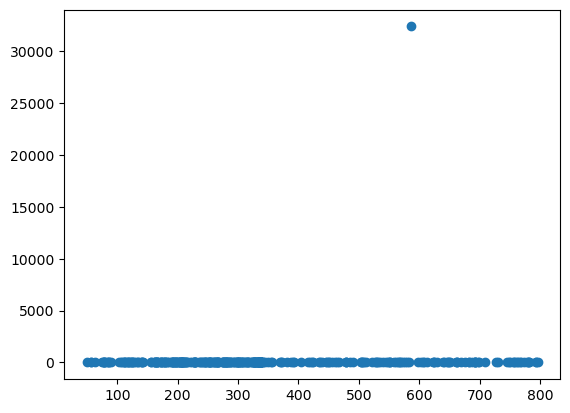

In [4]:
# Just a quick look at the data
plt.plot(gmdf["RuptureDistance"], gmdf["PGA"], marker="o", linestyle="none")

You should notice that the data doesn't look very interesting! This is because there
is one data point that is an outlier. The largest PGA values ever recorded are about
200-300%g. So remove any rows that are "unphysically large."

In [5]:
# Clearly, there is an outlier, so let's remove it:
gmdf = gmdf[gmdf["PGA"] < 200]

Now, create a new plot of the data and you should be able to see the decay of the PGA
values with distance. 

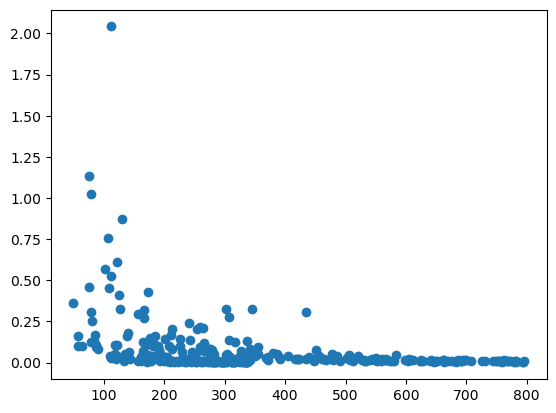

In [6]:
# Just a quick look at the data
plt.plot(gmdf["RuptureDistance"], gmdf["PGA"], marker="o", linestyle="none")

Still, most of the amplitude are very small with only a few
large values. This makes it difficult to see the structure of the data. One way to help
visualize the data is to use log axes for both the veritical and horizontal axes. 
So create a new plot with the same data but with log axes. 

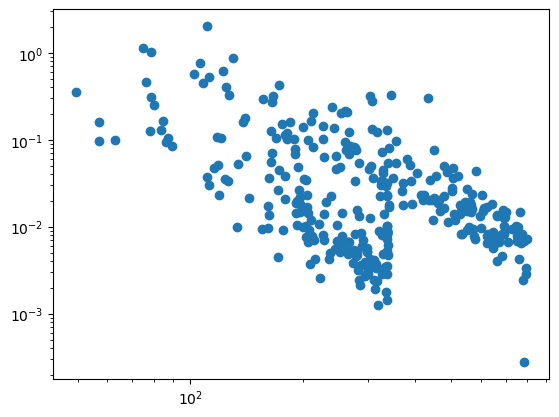

In [7]:
# The data is very skewed, so it can be useful to use log axes
plt.loglog(gmdf["RuptureDistance"], gmdf["PGA"], marker="o", linestyle="none")

You should now be able to see some hint in the structure of the data that the two 
earthquakes may be clearly separated.

To be able to clearly identify which points are from which earthquake, change the plot
to use a different color and/or marker symbol for the two different events. There are
multiple ways to do this with matplotlib, but one simple ways to separate the dataframe
into two separate dataframes corresponding to the two different earthqukea and then use
two different plot commands.

Start off by getting the unique set of event IDs from the dataframe:

In [8]:
gmdf["EarthquakeId"].unique()

array(['ci40964128', 'us7000ma74'], dtype=object)

Now create two different dataframes, one for each event

In [9]:
ci_df = gmdf[gmdf["EarthquakeId"] == "ci40964128"]
us_df = gmdf[gmdf["EarthquakeId"] == "us7000ma74"]

Be sure to label the axes with appropriate descriptions and units, and to include a
legend so that the viewer will know which earthquake goes with which events. 

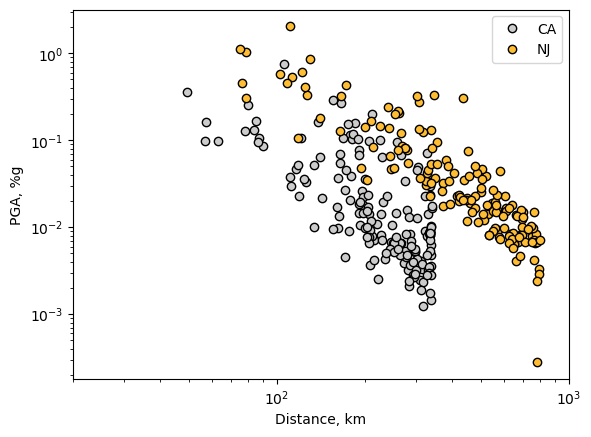

In [10]:
plt.loglog(
    ci_df["RuptureDistance"], ci_df["PGA"], 
    marker="o", linestyle="none", mfc="0.8", mec="black", label="CA"
)
plt.loglog(
    us_df["RuptureDistance"], us_df["PGA"], 
    marker="o", linestyle="none", mfc="#ffbd33", mec="black", label="NJ"
)
# The tick marks look bad with the default xlim, so I like to extend it a little bit
plt.xlim([20, 1000])
plt.legend()
plt.xlabel("Distance, km")
plt.ylabel("PGA, %g");

## Fit a curve to the data

Fitting a curve to the data is another useful tool for helping us explore the data.

The python package [statsmodels](https://www.statsmodels.org/dev/index.html) provides functions
for many different statistical methods, including linear regression. 

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

Since the PGA data look (kind of) linear when plotted on log-log axes, 
we should try to fit a linear curve for log(PGA) vs log(Distance). So 
we want to add log-transformed values as columns to the dataframes.

In [13]:
ci_df.loc[:, "lnDistance"] = np.log(ci_df["RuptureDistance"])
us_df.loc[:, "lnDistance"] = np.log(us_df["RuptureDistance"])

ci_df.loc[:, "lnPGA"] = np.log(ci_df["PGA"])
us_df.loc[:, "lnPGA"] = np.log(us_df["PGA"])

ci_mod = smf.ols(formula='lnPGA ~ lnDistance', data=ci_df)
ci_result = ci_mod.fit()
us_mod = smf.ols(formula='lnPGA ~ lnDistance', data=us_df)
us_result = us_mod.fit()

ci_pars = np.array(ci_result.params)
us_pars = np.array(us_result.params)

Now we will add the curves to the plot

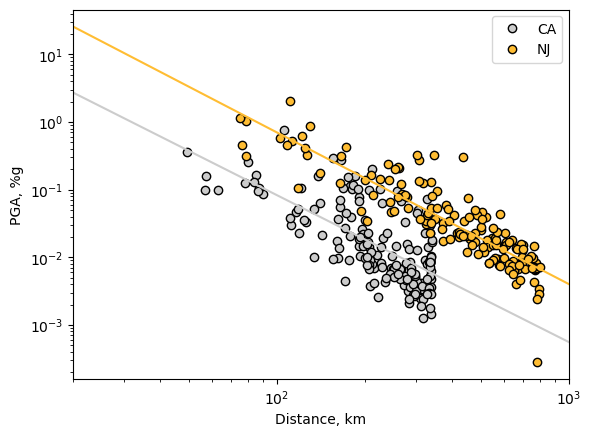

In [14]:
plt.loglog(
    ci_df["RuptureDistance"], ci_df["PGA"], 
    marker="o", linestyle="none", mfc="0.8", mec="black", label="CA"
)
plt.loglog(
    us_df["RuptureDistance"], us_df["PGA"], 
    marker="o", linestyle="none", mfc="#ffbd33", mec="black", label="NJ"
)

dgrid = np.logspace(np.log10(20), 3.0, 300)
ln_dgrid = np.log(dgrid)
ci_curve = np.exp(ci_pars[0] + ci_pars[1] * ln_dgrid)
us_curve = np.exp(us_pars[0] + us_pars[1] * ln_dgrid)

plt.loglog(dgrid, ci_curve, color="0.8")
plt.loglog(dgrid, us_curve, color="#ffbd33")
plt.xlim([20, 1000])
plt.legend()
plt.xlabel("Distance, km")
plt.ylabel("PGA, %g");

One issue is that the data are not really linear, so we should add some parameters
to allow the curve to fit the data better by adding additional terms. A non-logged 
distance term mimics the effects of anelastic attenuation, while the logged distance
term mimics the effects of geometrical attenuation.

In [15]:
ci_mod = smf.ols(formula='lnPGA ~ lnDistance + RuptureDistance', data=ci_df)
ci_result = ci_mod.fit()
us_mod = smf.ols(formula='lnPGA ~ lnDistance + RuptureDistance', data=us_df)
us_result = us_mod.fit()

ci_pars = np.array(ci_result.params)
us_pars = np.array(us_result.params)

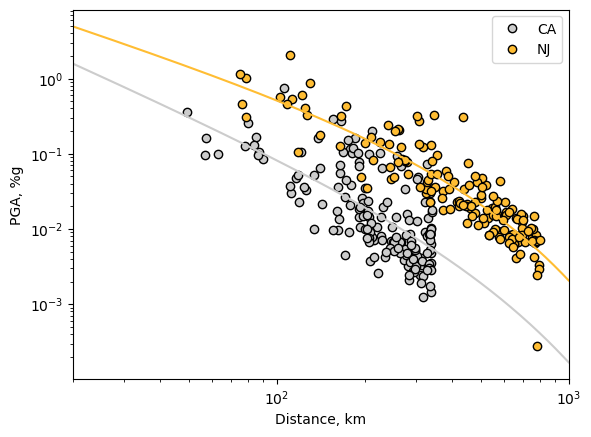

In [16]:
plt.loglog(
    ci_df["RuptureDistance"], ci_df["PGA"], 
    marker="o", linestyle="none", mfc="0.8", mec="black", label="CA"
)
plt.loglog(
    us_df["RuptureDistance"], us_df["PGA"], 
    marker="o", linestyle="none", mfc="#ffbd33", mec="black", label="NJ"
)

dgrid = np.logspace(np.log10(20), 3.0, 300)
ln_dgrid = np.log(dgrid)
ci_curve = np.exp(ci_pars[0] + ci_pars[1] * ln_dgrid + ci_pars[2] * dgrid)
us_curve = np.exp(us_pars[0] + us_pars[1] * ln_dgrid + us_pars[2] * dgrid)

plt.loglog(dgrid, ci_curve, color="0.8")
plt.loglog(dgrid, us_curve, color="#ffbd33")
plt.xlim([20, 1000])
plt.legend()
plt.xlabel("Distance, km")
plt.ylabel("PGA, %g");

## Make a map of the earthquakes and station data

For this, we will use cartopy. Note that cartopy isn't a dependency of gmprocess, so you will
need to install it in the gmprocess virtual environment.

In [17]:
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

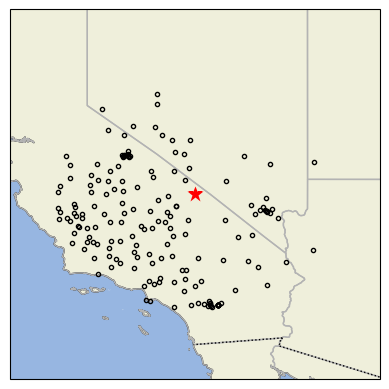

In [18]:
eq_lat = ci_df["EarthquakeLatitude"].iloc[0]
eq_lon = ci_df["EarthquakeLongitude"].iloc[0]
dll = 5.0
extent = [eq_lon - dll, eq_lon + dll, eq_lat - dll,  eq_lat + dll]

proj = ccrs.PlateCarree()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.set_extent(extent, crs=proj)

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, ec="0.7")
ax.add_feature(cfeature.BORDERS, linestyle=':')

ax.plot(eq_lon, eq_lat, marker="*", mfc="red", mec="none", ms=12)
ax.plot(
    ci_df["StationLongitude"], ci_df["StationLatitude"], 
    marker=".", ls="none", mfc="none", mec="k",
)

To reuse code for the other earthquake, we could copy/paste it from above
and edit it. But it would be better to define a function that can be reused.

In [19]:
def eq_map(df, dll=5.0):
    """Function to plot a map of the earthquake and stations.

    Args:
        df (pd.DataFrame):
            DataFrame with ground motion data.
        dll (float):
            Padding value to expand map around epicenter, in units of decimal degrees.
    """
    eq_lat = df["EarthquakeLatitude"].iloc[0]
    eq_lon = df["EarthquakeLongitude"].iloc[0]
    extent = [eq_lon - dll, eq_lon + dll, eq_lat - dll,  eq_lat + dll]
    
    proj = ccrs.PlateCarree()
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.set_extent(extent, crs=proj)
    
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES, ec="0.7")
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    ax.plot(eq_lon, eq_lat, marker="*", mfc="red", mec="none", ms=12)
    ax.plot(
        df["StationLongitude"], df["StationLatitude"], 
        marker=".", ls="none", mfc="none", mec="k",
    )

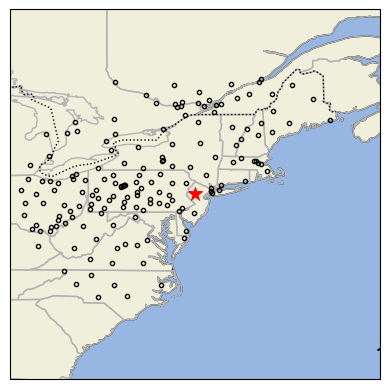

In [20]:
eq_map(df=us_df, dll=10)

One thing that this is missing is an indication of the spatial pattern in the 
shaking intensity. We can add that by setting the color of the points based on
the PGA value. We'll need to define a 
[colormap](https://matplotlib.org/stable/users/explain/colors/colormaps.html)
and an array to define the colors. 

As with the previous plots, it is helpful to take use a logarithmic scale for 
the shaking intensity colors. The easiest way to do this is to compute the log
of PGA.

In [21]:
def eq_map_color(df, dll=5.0):
    eq_lat = df["EarthquakeLatitude"].iloc[0]
    eq_lon = df["EarthquakeLongitude"].iloc[0]
    extent = [eq_lon - dll, eq_lon + dll, eq_lat - dll,  eq_lat + dll]
    
    proj = ccrs.PlateCarree()
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.set_extent(extent, crs=proj)
    
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES, ec="0.7")
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    ax.plot(eq_lon, eq_lat, marker="*", mfc="red", mec="none", ms=12)
    cb = ax.scatter(
        df["StationLongitude"], df["StationLatitude"], 
        c=np.log(df["PGA"]), cmap="Spectral_r", ec="k"
    )
    fig.colorbar(cb, label="ln(PGA), %g")

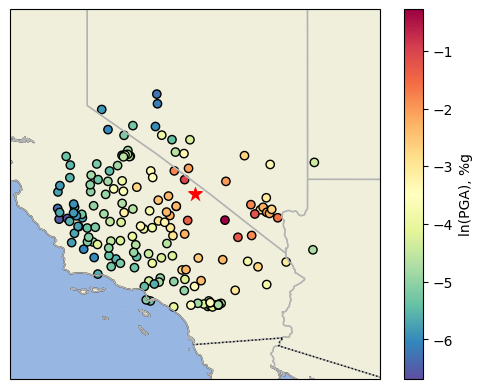

In [22]:
eq_map_color(df=ci_df)

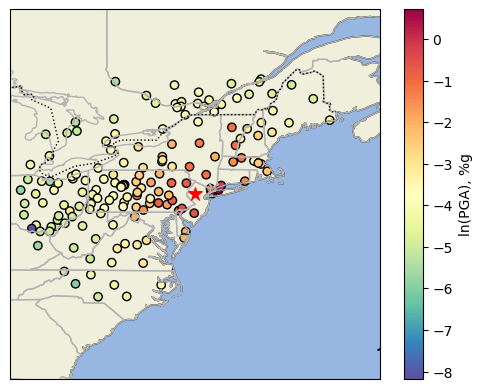

In [23]:
eq_map_color(df=us_df, dll=10)